###GBM
Gradient Boosting trains many models in a gradual, additive and sequential manner.Gradient boosting performs the same by using gradients in the loss function (y=ax+b+e , e needs a special mention as it is the error term). The loss function is a measure indicating how good are model’s coefficients are at fitting the underlying data. A logical understanding of loss function would depend on what we are trying to optimise.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from util import plot_2d_data

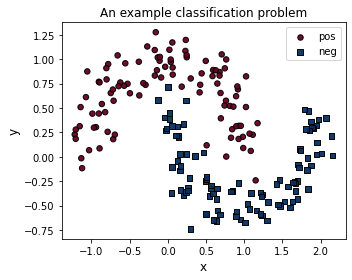

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.15, random_state=13)
y = 2 * y - 1
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2d_data(ax, X, y, xlabel='x', ylabel='y', s=30,
             title='An example classification problem', 
             legend=['pos', 'neg'], colormap='RdBu')
fig.tight_layout()

In [7]:
import numpy as np
f = np.full((len(y), ), fill_value=0.0)
residuals = -(y - f)

In [8]:
from sklearn.tree import DecisionTreeRegressor
h = DecisionTreeRegressor(max_depth=1)
h.fit(X, -residuals)  
# Observe the negated residuals: we want to approximate the negative gradient

DecisionTreeRegressor(max_depth=1)

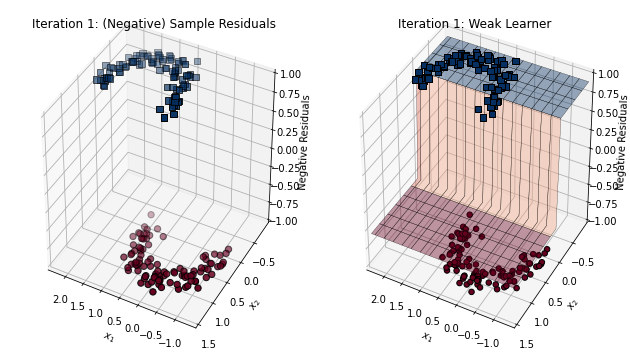

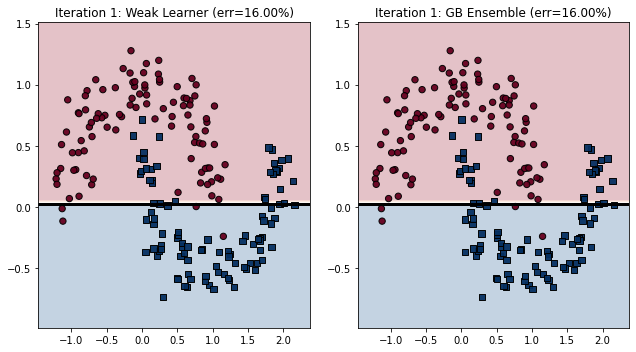

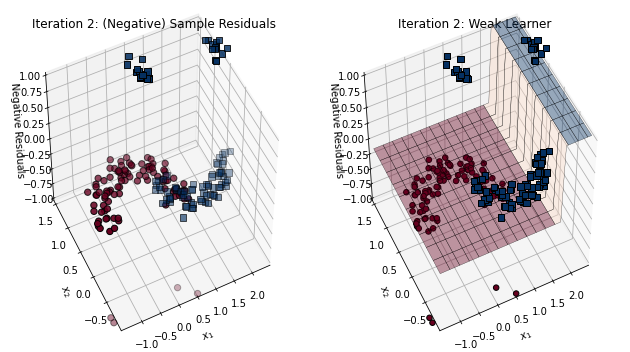

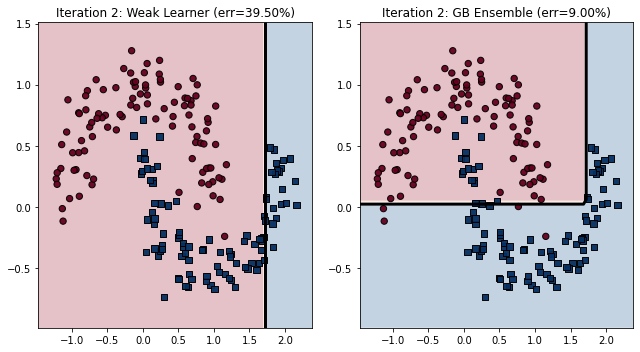

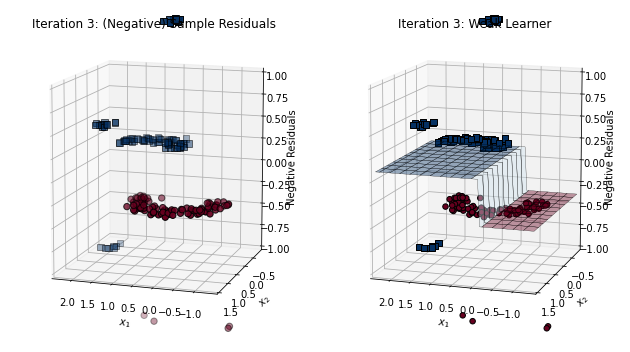

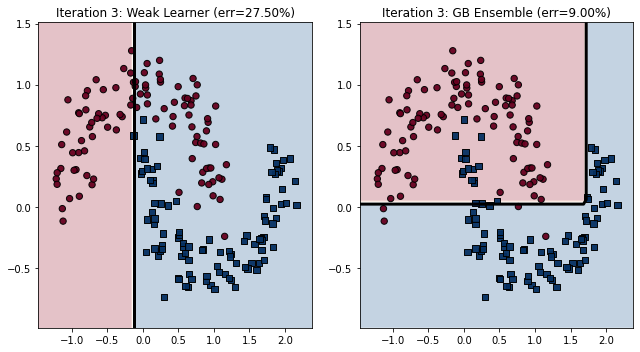

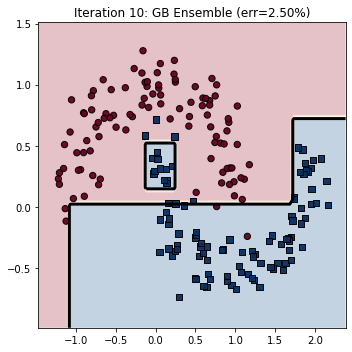

In [10]:
%matplotlib inline

from visualization import plot_2d_classifier, get_colors
from scipy.optimize import minimize_scalar
from sklearn.metrics import accuracy_score

# Set up a mesh for 3d plotting
xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05), 
                           np.arange(yMin, yMax, 0.05))

cm = get_colors(n_colors=2, colormap='RdBu')
views = [(36, 118), (48, -116), (11, 108)]

# Initialize
n_samples, n_features = X.shape
n_estimators = 10
ensemble = []
F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble

for t in range(n_estimators):
    # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
    residuals = y - F
    h = DecisionTreeRegressor(max_depth=1)
    h.fit(X, residuals)

    # ----------------------------------------------    
    # Visualize the residuals and their fit in 3d
    if t in [0, 1, 2]:
        fig = plt.figure(figsize=(9, 5))
        
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.view_init(elev=views[t][0], azim=views[t][1])
        ax.scatter(X[y<0, 0], X[y<0, 1], residuals[y<0], c=cm[0], 
                   marker='o', s=40, edgecolors='k')
        ax.scatter(X[y>0, 0], X[y>0, 1], residuals[y>0], c=cm[1], 
                   marker='s', s=40, edgecolors='k')
        ax.set_xlabel('$x_1$')
        ax.set_xlim(xMin, xMax)
        ax.set_ylabel('$x_2$')
        ax.set_ylim(yMin, yMax)
        ax.set_zlabel('Negative Residuals')
        ax.set_zlim(-1, 1)
        ax.set_title('Iteration {0}: (Negative) Sample Residuals '.format(t + 1))

        ax = fig.add_subplot(1, 2, 2, projection='3d')
        zMesh = h.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
        zMesh = zMesh.reshape(xMesh.shape)
        ax.plot_surface(xMesh, yMesh, zMesh, rstride=5, cstride=5, 
                        alpha=0.4, linewidth=0.25, edgecolors='k', cmap='RdBu')
        ax.view_init(elev=views[t][0], azim=views[t][1])
        ax.scatter(X[y<0, 0], X[y<0, 1], residuals[y<0], c=cm[0], 
                   marker='o', s=30, alpha=1, edgecolors='k')
        ax.scatter(X[y>0, 0], X[y>0, 1], residuals[y>0], c=cm[1], 
                   marker='s', s=40, alpha=1, edgecolors='k')
        ax.set_xlabel('$x_1$')
        ax.set_xlim(xMin, xMax)
        ax.set_ylabel('$x_2$')
        ax.set_ylim(yMin, yMax)
        ax.set_zlabel('Negative Residuals')
        ax.set_zlim(-1, 1)
        ax.set_title('Iteration {0}: Weak Learner'.format(t + 1))
        
        fig.tight_layout()
        pngFile = 'figures/F{0:2d}_figure.png'.format(2*t + 11)
        plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)
    # ----------------------------------------------   

    # Compute a step length that produces the best improvement in the loss
    hreg = h.predict(X)
    loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
    step = minimize_scalar(loss, method='golden')
    a = step.x
      
    # Compute the error of the new classifier
    F += a * hreg
    
    # Update the ensemble
    ensemble.append((a, h))
    
    # ----------------------------------------------   
    # Plot the classification of the weak learner and the overall ensemble
    h_as_classifier = lambda x: 2 * (h.predict(x) >= 0).astype(int) - 1
    F_as_classifier = lambda x: 2 * (np.sum([a * h.predict(x) for (a, h) in ensemble], axis=0) >= 0).astype(int) - 1
     
    hpred = h_as_classifier(X)
    herr = 1 - accuracy_score(y, hpred)
        
    Fpred = F_as_classifier(X)
    Ferr = 1 - accuracy_score(y, Fpred)
    
    if t in [0, 1, 2]: 
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
        plot_2d_classifier(ax[0], X, y, predict_function=h_as_classifier, s=40,
                           alpha=0.25, xlabel=None, ylabel=None, colormap='RdBu',
                           title='Iteration {0}: Weak Learner (err={1:4.2f}%)'.format(t + 1, herr*100))

        plot_2d_classifier(ax[1], X, y, predict_function=F_as_classifier, s=40,
                           alpha=0.25, xlabel=None, ylabel=None, colormap='RdBu', 
                           title='Iteration {0}: GB Ensemble (err={1:4.2f}%)'.format(t + 1, Ferr*100))    
        fig.tight_layout()
        pngFile = 'figures/F{0:2d}_figure.png'.format(2*t + 12)
        plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)
        
    elif t == 9:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        plot_2d_classifier(ax, X, y, predict_function=F_as_classifier, s=40,
                           alpha=0.25, xlabel=None, ylabel=None, colormap='RdBu', 
                           title='Iteration {0}: GB Ensemble (err={1:4.2f}%)'.format(t + 1, Ferr*100))    

        fig.tight_layout()
        pngFile = 'figures/F{0:2d}_figure.png'.format(2*t + 13)
        plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)
    # ----------------------------------------------   

### Implementing Gradient Boosting

The basic algorithm can be outlined with the following pseudocode:

``Initialize the ensemble: F=f_0``, some constant value

``for t = 1 to T:``
   1. compute the residuals for each example, $r_i^t=-∂L/∂F(x_i)$ 
   2. fit a weak decision tree regressor $h_t (x)$ using the training set $(x_i,r_i )_(i=1)^n$
   3. compute the step length ($\alpha_t$) using line search 
   4. update the model: $F = F + \alpha_t⋅ h_t (x)$
   

In [14]:
def fit_gradient_boosting(X, y, n_estimators=10):
     # Initialize
    n_samples, n_features = X.shape
    n_estimators = 10
    estimators = []
    F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble
    
    for t in range(n_estimators):
        # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
        residuals = y - F
        h = DecisionTreeRegressor(max_depth=1)
        h.fit(X, residuals)
    
        # Compute a step length that produces the best improvement in the loss
        hreg = h.predict(X)
        loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
        step = minimize_scalar(loss, method='golden')
        a = step.x

        # Update the ensemble predictions
        F += a * hreg

        # Update the ensemble
        estimators.append((a, h))
    
    return estimators

In [16]:
def predict_gradient_boosting(X, estimators):
    pred = np.zeros((X.shape[0], ))

    for a, h in estimators:
        pred += a * h.predict(X)

    y = np.sign(pred)

    return y

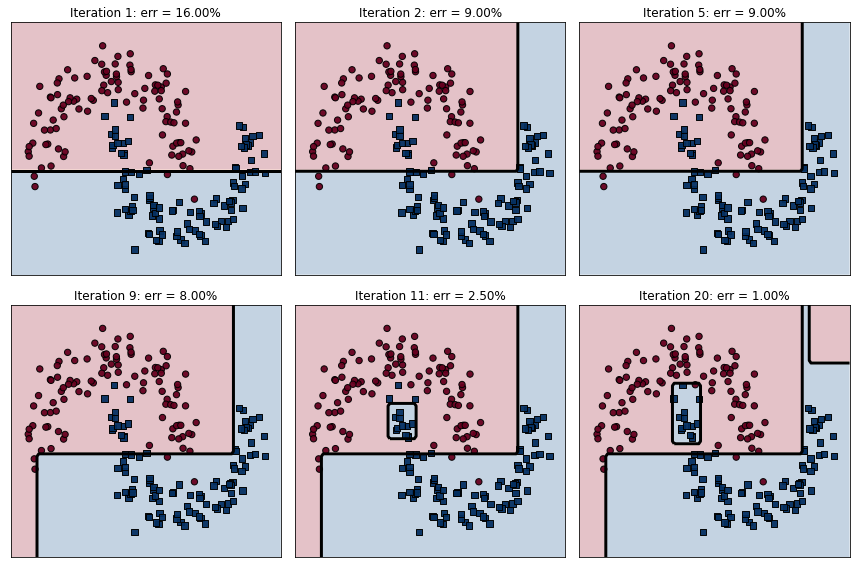

In [17]:
%matplotlib inline

n_estimators = 20
estimators = []                  # Initialize an empty ensemble  
F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble
                                  
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
subplot_id = -1
for t in range(n_estimators):
    # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
    residuals = y - F
    h = DecisionTreeRegressor(max_depth=1)
    h.fit(X, residuals)

    # Compute a step length that produces the best improvement in the loss
    hreg = h.predict(X)
    loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
    step = minimize_scalar(loss, method='golden')
    a = step.x

    # Update the ensemble predictions
    F += a * hreg

    # Update the ensemble
    estimators.append((a, h))

    # Plot the ensemble
    if t in [0, 1, 4, 8, 10, 19]:
        subplot_id += 1
        r, c = np.divmod(subplot_id, 3)
        err = (1 - accuracy_score(y, predict_gradient_boosting(X, estimators))) * 100

        title = 'Iteration {0}: err = {1:4.2f}%'.format(t + 1, err)
        plot_2d_classifier(ax[r, c], X, y, 
                           predict_function=predict_gradient_boosting, predict_args=estimators,
                           alpha=0.25, xlabel=None, ylabel=None, boundary_level=[0.0],
                           title=title, colormap='RdBu', s=40)
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        
fig.tight_layout()